In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    r2_score, mean_absolute_percentage_error
)
import xgboost as xgb
import lightgbm as lgb
import shap

import sys
sys.path.append('..')
import config

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed
np.random.seed(config.RANDOM_SEED)

print("Libraries imported successfully")

Configuration loaded successfully!
Project root: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling
Random seed: 42
Target sample size: 1000 personnel
Libraries imported successfully


# Load Dataset

In [15]:
#load dataset 
data_path = config.PROCESSED_DATA_DIR/config.FEATURES_ENGINEERED_FILE
df = pd.read_csv(data_path)

print(f"Data Shape: {df.shape}")
print("Readiness score statistics:")
print(df['readiness_score'].describe())

Data Shape: (1000, 75)
Readiness score statistics:
count    1000.000000
mean       71.153700
std         9.110339
min        42.400000
25%        64.900000
50%        71.300000
75%        77.525000
max        99.300000
Name: readiness_score, dtype: float64


# Data Preparation

In [23]:
leakage_features = [
    'unit_avg_readiness', 'relative_readiness'
]


In [24]:
#seperate features and target 
X = df.drop(['attrition_risk', 'readiness_score'] + leakage_features, axis=1)
y = df['readiness_score']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

#encode categorical features 
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical features: {len(categorical_features)}")

#one-hot encode
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\nFeatures after encoding: {X_encoded.shape}")

Features shape: (1000, 71)
Target shape: (1000,)

Categorical features: 12

Features after encoding: (1000, 98)


In [25]:
#train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_SEED
)

print("Dataset splits:")
print(f" Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%})")
print(f" Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%})")

Dataset splits:
 Training: 800 samples (80.0%)
 Test: 200 samples (20.0%)


In [26]:
#feature scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#store feature names 
feature_names = X_encoded.columns.tolist()

print(f"Features scaled")
print(f"Total Features: {len(feature_names)}")

Features scaled
Total Features: 98


# Model Training 

#### Baseline: Linear Regression 

In [29]:
print("Training Linear Regreassion....")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

#predictions 
y_pred_lr = lr_model.predict(X_test_scaled)

#metrics for evaluation 
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("\nLinear Regression trained....")
print(f"RMSE {rmse_lr:.2f}")
print(f"R square: {r2_lr:.3f}")
print(f"MAE: {mae_lr:.2f}")
print(f"MAPE:{mape_lr:.2f}")


Training Linear Regreassion....

Linear Regression trained....
RMSE 5.45
R square: 0.656
MAE: 4.35
MAPE:0.06


### Random Forest Regressor 

In [34]:
print("Training Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    random_state=config.RANDOM_SEED,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

#prediction
y_pred_rf = rf_model.predict(X_test)

#metrics 
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print("\nRandom Forest trained")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R squared: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")

Training Random Forest Regressor...

Random Forest trained
RMSE: 6.04
R squared: 0.578
MAE: 4.86
MAPE: 0.07%


### XGBoost Regressor 

In [78]:
print("Training XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(
    n_estimators = 200,
    max_depth=7,
    learning_rate =0.1,
    objective='reg:squarederror',
    random_state = config.RANDOM_SEED,
    tree_method='hist',
    verbosity=1
)

xgb_model.fit(X_train, y_train, verbose=True)

#predictions 
y_pred_xgb = xgb_model.predict(X_test)

#metrics 
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("\nXGBoost trained..")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R squared: {r2_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}")

Training XGBoost Regressor...

XGBoost trained..
RMSE: 5.90
R squared: 0.60
MAE: 4.71
MAPE: 0.07


### LightGBM Regressor 

In [61]:
print("Training LightGBM Regressor...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    random_state=config.RANDOM_SEED,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

#predictions
y_pred_lgb = lgb_model.predict(X_test)

#metrics
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb) * 100

print("\nLightGBM trained")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"R²: {r2_lgb:.3f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"MAPE: {mape_lgb:.2f}%")

Training LightGBM Regressor...

LightGBM trained
RMSE: 5.74
R²: 0.619
MAE: 4.67
MAPE: 6.69%


# Model Comparison 

In [79]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_lgb],
    'R²': [r2_lr, r2_rf, r2_xgb, r2_lgb],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_lgb],
    'MAPE (%)': [mape_lr, mape_rf, mape_xgb, mape_lgb]
})

#add status indicators
comparison_df['Meets RMSE (≤8)'] = comparison_df['RMSE'].apply(
    lambda x: 'True' if x <= config.READINESS_RMSE_TARGET else 'False'
)
comparison_df['Meets R² (≥0.70)'] = comparison_df['R²'].apply(
    lambda x: 'True' if x >= config.READINESS_R2_TARGET else 'False'
)

#round metrics
comparison_df['RMSE'] = comparison_df['RMSE'].round(2)
comparison_df['R²'] = comparison_df['R²'].round(3)
comparison_df['MAE'] = comparison_df['MAE'].round(2)
comparison_df['MAPE (%)'] = comparison_df['MAPE (%)'].round(2)

print("MODEL COMPARISON - TEST SET")
print(comparison_df.to_string(index=False))

#identify best model (lowest RMSE)
best_model_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n Best Model (lowest RMSE): {best_model_name}")

MODEL COMPARISON - TEST SET
            Model  RMSE    R²  MAE  MAPE (%) Meets RMSE (≤8) Meets R² (≥0.70)
Linear Regression  5.45 0.656 4.35      0.06            True            False
    Random Forest  6.04 0.578 4.86      0.07            True            False
          XGBoost  5.90 0.598 4.71      0.07            True            False
         LightGBM  5.74 0.619 4.67      6.69            True            False

 Best Model (lowest RMSE): Linear Regression


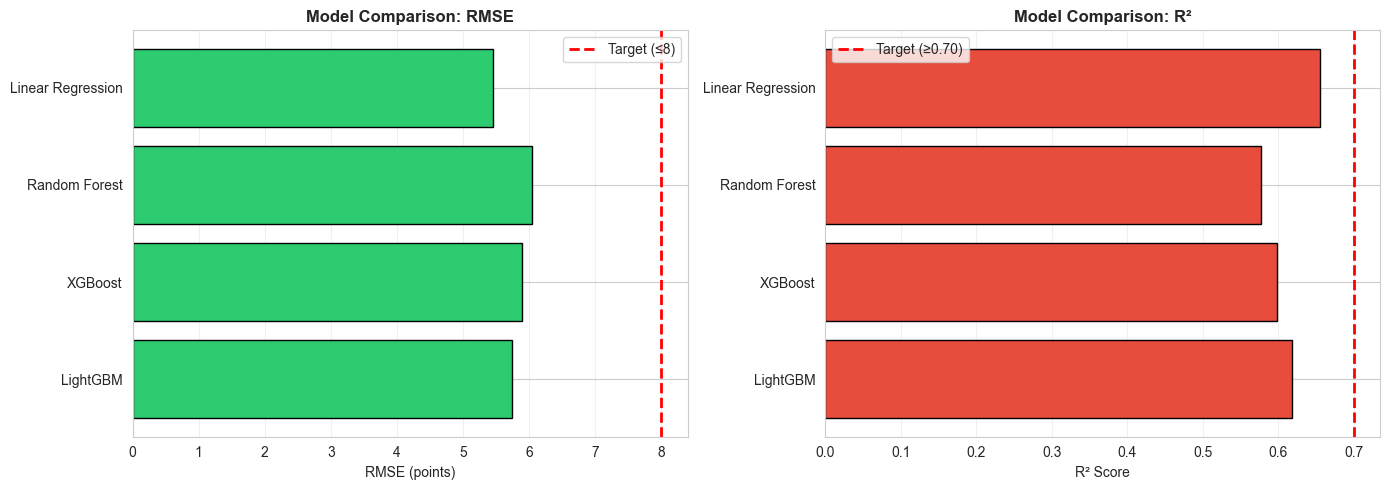

Model comparison visualization saved


In [80]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE comparison
colors_rmse = ['#e74c3c' if x > 8 else '#2ecc71' for x in comparison_df['RMSE']]
axes[0].barh(comparison_df['Model'], comparison_df['RMSE'], color=colors_rmse, edgecolor='black')
axes[0].axvline(x=8, color='red', linestyle='--', linewidth=2, label='Target (≤8)')
axes[0].set_xlabel('RMSE (points)')
axes[0].set_title('Model Comparison: RMSE', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: R² comparison
colors_r2 = ['#e74c3c' if x < 0.70 else '#2ecc71' for x in comparison_df['R²']]
axes[1].barh(comparison_df['Model'], comparison_df['R²'], color=colors_r2, edgecolor='black')
axes[1].axvline(x=0.70, color='red', linestyle='--', linewidth=2, label='Target (≥0.70)')
axes[1].set_xlabel('R² Score')
axes[1].set_title('Model Comparison: R²', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'readiness_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved")

## Model Evaluation(Linear Regression)

In [84]:
#select best model
models_dict = {
    'Linear Regression': (lr_model, y_pred_lr, X_test_scaled),
    'Random Forest': (rf_model, y_pred_rf, X_test),
    'XGBoost': (xgb_model, y_pred_xgb, X_test),
    'LightGBM': (lgb_model, y_pred_lgb, X_test)
}

best_model, y_pred_best, X_test_best = models_dict[best_model_name]

#calculate final metrics
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_final = r2_score(y_test, y_pred_best)
mae_final = mean_absolute_error(y_test, y_pred_best)
mape_final = mean_absolute_percentage_error(y_test, y_pred_best) * 100

print("\n" + "-"*80)
print(f"FINAL MODEL EVALUATION - {best_model_name}")
print("-"*80)
print(f"RMSE: {rmse_final:.2f} points (Target: ≤ {config.READINESS_RMSE_TARGET})")
print(f"R²: {r2_final:.3f} (Target: ≥ {config.READINESS_R2_TARGET})")
print(f"MAE: {mae_final:.2f} points (Target: ≤ {config.READINESS_MAE_TARGET})")
print(f"MAPE: {mape_final:.2f}% (Target: ≤ {config.READINESS_MAPE_TARGET}%)")




--------------------------------------------------------------------------------
FINAL MODEL EVALUATION - Linear Regression
--------------------------------------------------------------------------------
RMSE: 5.45 points (Target: ≤ 8.0)
R²: 0.656 (Target: ≥ 0.7)
MAE: 4.35 points (Target: ≤ 6.0)
MAPE: 6.20% (Target: ≤ 10.0%)


## Residual Analysis 

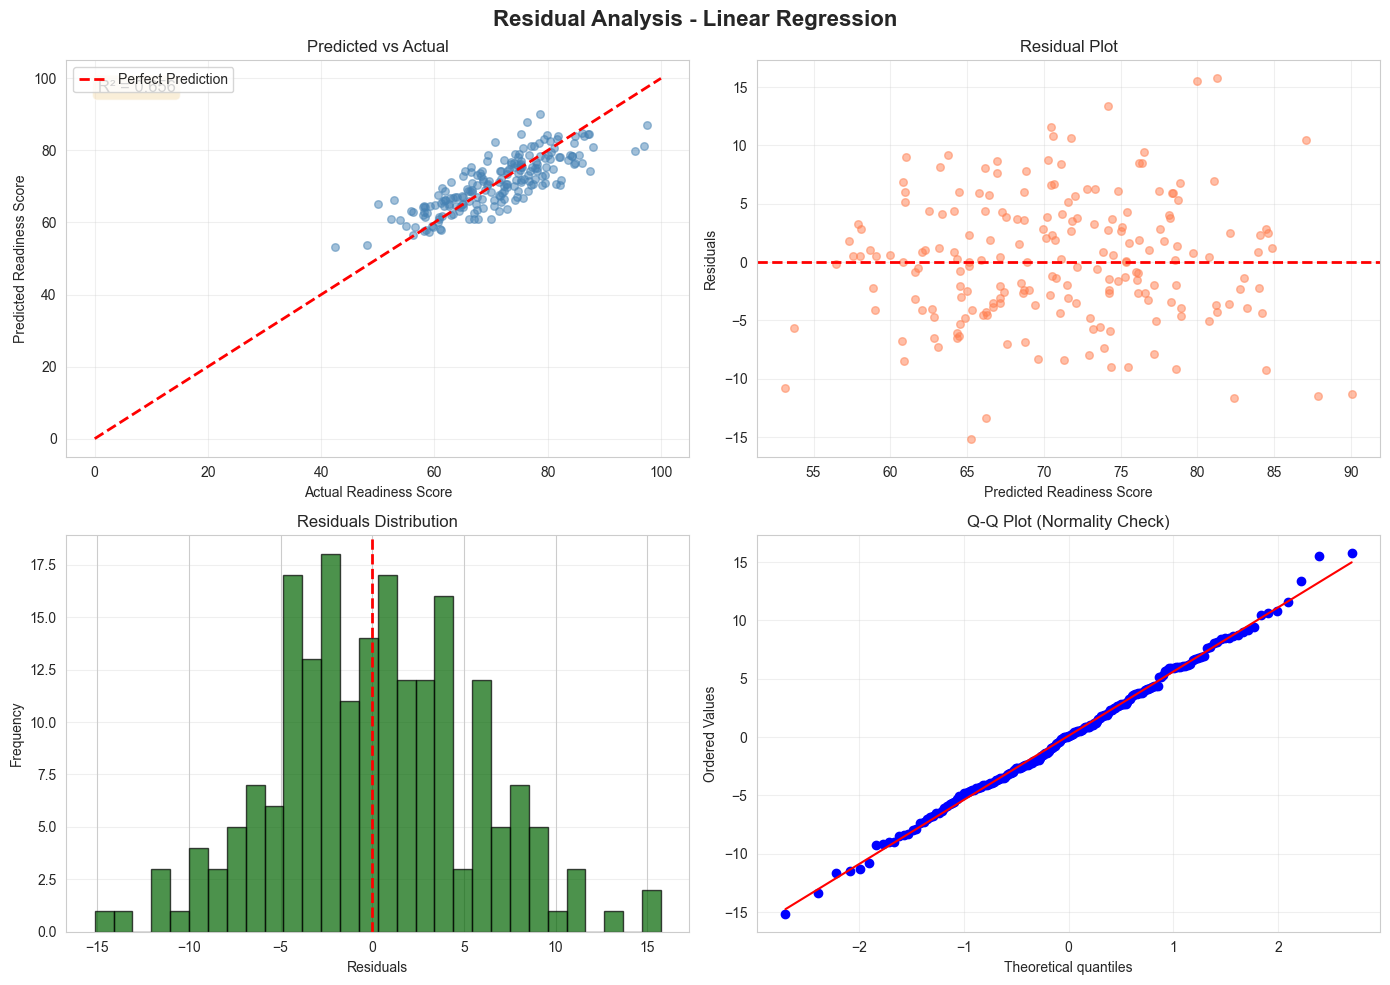

Residual analysis saved

Residuals Statistics:
  Mean: 0.116
  Std Dev: 5.466
  Min: -15.14
  Max: 15.75


In [86]:
# Calculate residuals
residuals = y_test - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {best_model_name}', fontsize=16, fontweight='bold')

# Plot 1: Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5, c='steelblue', s=30)
axes[0, 0].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Readiness Score')
axes[0, 0].set_ylabel('Predicted Readiness Score')
axes[0, 0].set_title('Predicted vs Actual')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Add R² to plot
axes[0, 0].text(0.05, 0.95, f'R² = {r2_final:.3f}', 
                transform=axes[0, 0].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Residuals vs Predicted
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, c='coral', s=30)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Readiness Score')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Residuals distribution
axes[1, 0].hist(residuals, bins=30, color='darkgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residuals Distribution')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Q-Q plot (normality check)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'readiness_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Residual analysis saved")
print(f"\nResiduals Statistics:")
print(f"  Mean: {residuals.mean():.3f}")
print(f"  Std Dev: {residuals.std():.3f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

## Feature Importance Analysis 

In [87]:
# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Top 15 features
    top_15 = feature_importance_df.head(15)
    
    print("\nTop 15 Most Important Features for Readiness:")
    print("-"*60)
    for idx, row in top_15.iterrows():
        print(f"{row['feature']:45s}: {row['importance']:.4f}")
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_15)), top_15['importance'].values, color='darkgreen', edgecolor='black')
    plt.yticks(range(len(top_15)), top_15['feature'].values)
    plt.xlabel('Feature Importance', fontweight='bold')
    plt.title(f'Top 15 Features - {best_model_name}\nReadiness Score Prediction', fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(config.FIGURES_DIR / 'readiness_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save to CSV
    feature_importance_df.to_csv(config.REPORTS_DIR / 'readiness_feature_importance.csv', index=False)
    
    print("\n Feature importance saved")
else:
    print("\n  Model does not have feature_importances_ attribute")
    
    # For Linear Regression, use coefficients
    if best_model_name == 'Linear Regression':
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': best_model.coef_
        }).sort_values('coefficient', key=abs, ascending=False)
        
        print("\nTop 15 Features by Absolute Coefficient:")
        print(coef_df.head(15).to_string(index=False))


  Model does not have feature_importances_ attribute

Top 15 Features by Absolute Coefficient:
                          feature  coefficient
               skill_decay_factor    14.951456
           training_recency_score   -12.508254
                 years_of_service    10.905328
            time_in_rank_estimate    -6.889066
                    commendations    -4.686401
         performance_review_score     4.142963
commendations_to_discipline_ratio     4.100016
         days_since_last_training    -3.743904
                     health_index     3.389067
         health_performance_index    -3.216617
                  rank_avg_health     3.057640
                     rank_Officer    -2.403661
              certifications_held     2.189760
              training_efficiency    -1.945818
    specialized_courses_completed     1.500835


## SHAP Analysis 

In [88]:
# Only compute SHAP for tree models
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    print("Computing SHAP values...")
    
    # Sample for faster computation
    sample_size = min(200, len(X_test))
    X_test_sample = X_test.sample(n=sample_size, random_state=config.RANDOM_SEED)
    
    # Create explainer
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    print("SHAP values computed")
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot - Readiness Score', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(config.FIGURES_DIR / 'readiness_shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # SHAP bar plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                      plot_type='bar', show=False)
    plt.title('SHAP Feature Importance - Readiness Score', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(config.FIGURES_DIR / 'readiness_shap_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("SHAP visualizations saved")
else:
    print("\nSHAP analysis only available for tree-based models")


SHAP analysis only available for tree-based models


## Save Model and Artifacts 

In [90]:
#save the best model
model_path = config.MODELS_DIR / config.READINESS_MODEL_FILE
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

#save the scaler
scaler_path = config.MODELS_DIR / config.READINESS_SCALER_FILE
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

#save feature names
features_path = config.MODELS_DIR / config.READINESS_FEATURES_FILE
with open(features_path, 'w') as f:
    f.write('\n'.join(feature_names))
print(f"Feature names saved to: {features_path}")

Model saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\models\readiness_regressor.pkl
Scaler saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\models\readiness_scaler.pkl
Feature names saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\models\readiness_features.txt


In [91]:
#save model performance metrics
performance_metrics = {
    'model_name': best_model_name,
    'test_rmse': rmse_final,
    'test_r2': r2_final,
    'test_mae': mae_final,
    'test_mape': mape_final,
    'meets_rmse_target': rmse_final <= config.READINESS_RMSE_TARGET,
    'meets_r2_target': r2_final >= config.READINESS_R2_TARGET,
    'meets_mae_target': mae_final <= config.READINESS_MAE_TARGET,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(feature_names)
}

metrics_df = pd.DataFrame([performance_metrics])
metrics_path = config.REPORTS_DIR / 'readiness_model_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Performance metrics saved to: {metrics_path}")

Performance metrics saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\reports\readiness_model_metrics.csv
